데이터 로드

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rc("font", family="Malgun Gothic")
pd.reset_option("display.max_rows")

In [3]:
df = pd.read_csv('data.csv')
df.head(2)

,name,price,description,item_condition,sale_status,likes,views,shipping_fee,image_url,location,tags,inspectable,link,update_time,brand_name,desc_len,image_count,middle_category,last_category,interest_score
0,글로니 리반 퍼자켓 카멜,230000,3번 착용했고 하자나 얼룩 없습니다!,4,1,10,133,4000,['https://media.bunjang.co.kr/product/31631544...,NaN,"글로니, 퍼자켓, 글로니퍼자켓, glowny",False,https://m.bunjang.co.kr/products/316315443,2025-06-27 18:02:26,글로니,20,2,아우터,자켓,0.07
1,글로니 terry pk long sleeve,80000,시착후 보관중입니당 pk 롱슬리브 스트라이프 블루,5,1,14,58,0,['https://media.bunjang.co.kr/product/33478587...,NaN,NaN,False,https://m.bunjang.co.kr/products/334785874,2025-06-27 18:35:00,글로니,27,2,상의,긴팔 티셔츠,0.24


수치형 변수 분석

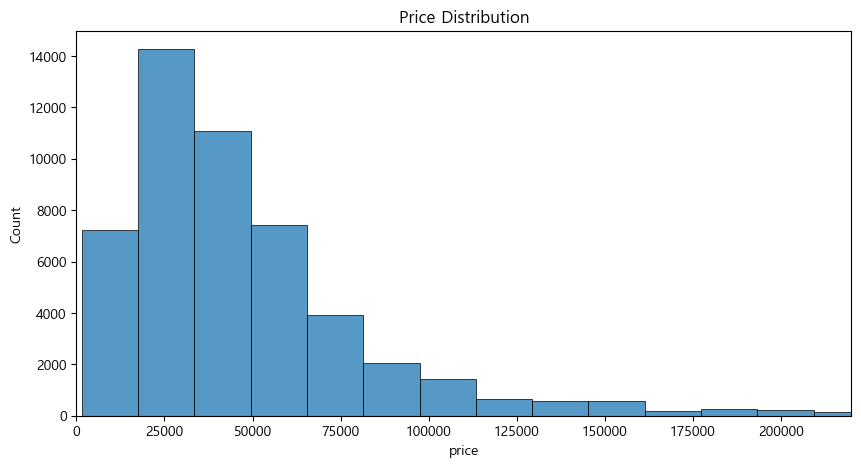

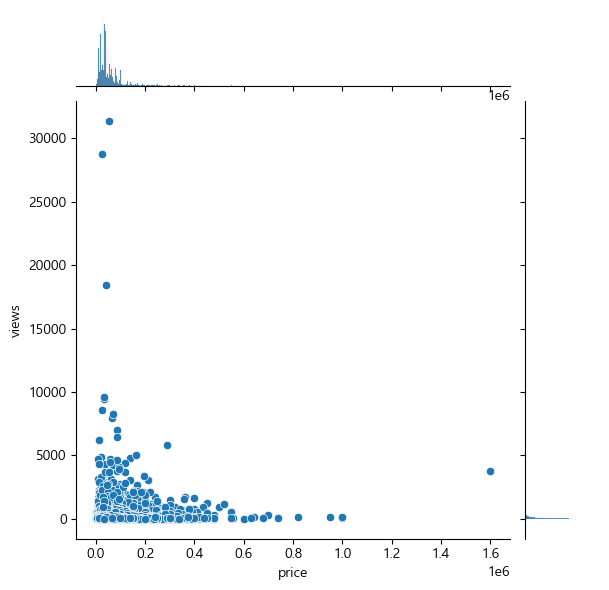

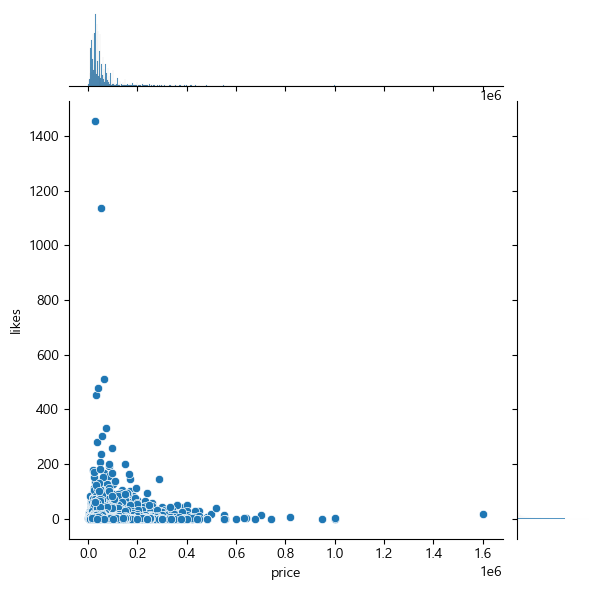

In [4]:
# 가격 분포
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=100)
plt.xlim(0, df['price'].quantile(0.99))  # 극단값 제외
plt.title('Price Distribution')
plt.show()

# 가격과 조회수/찜수의 관계
sns.jointplot(data=df, x='price', y='views', kind='scatter')
sns.jointplot(data=df, x='price', y='likes', kind='scatter')

In [5]:
# 위 시각화를 통해 데이터가 skewed 되어있음을 확인 > 로그변환

df['log_price'] = np.log1p(df['price'])

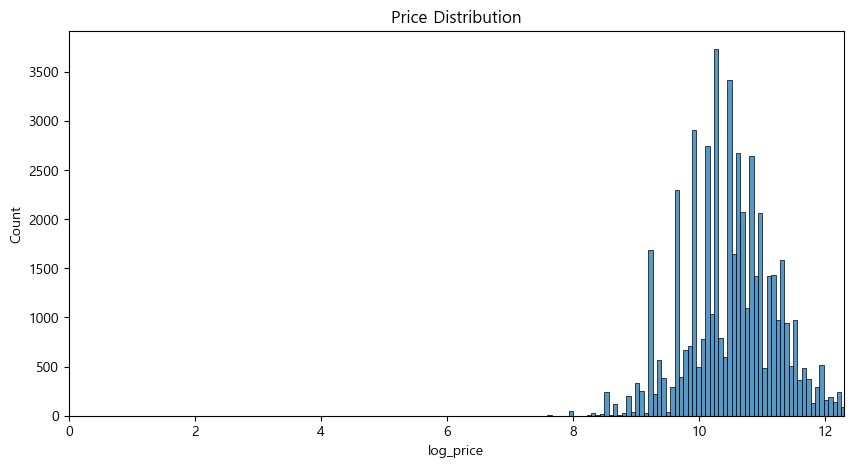

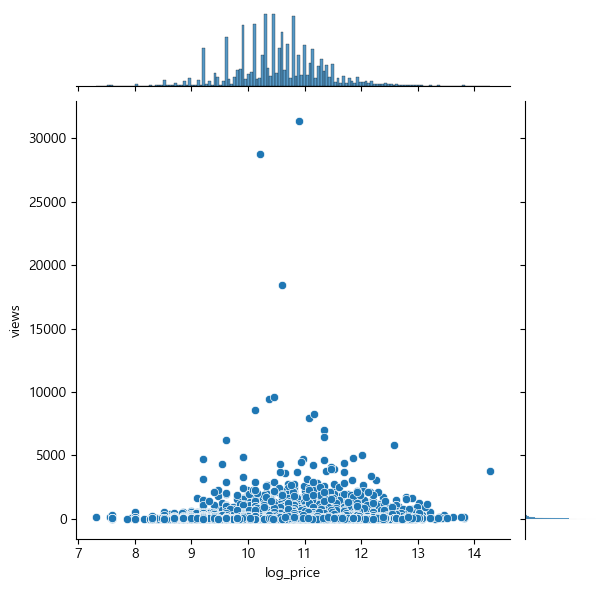

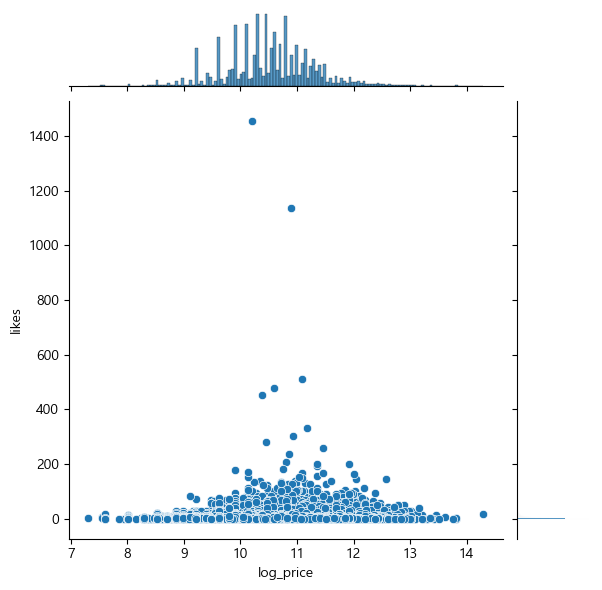

In [6]:
# 가격 분포
plt.figure(figsize=(10, 5))
sns.histplot(df['log_price'], bins=100)
plt.xlim(0, df['log_price'].quantile(0.99))  # 극단값 제외
plt.title('Price Distribution')
plt.show()

# 가격과 조회수/찜수의 관계
sns.jointplot(data=df, x='log_price', y='views', kind='scatter')
sns.jointplot(data=df, x='log_price', y='likes', kind='scatter')

In [7]:
#위 시각화 통해 skewness는 줄여볼 수 있었으나 상관관계 뚜렷하지 않음 > 이상치 제거

from scipy import stats
numeric_cols = ['price', 'likes', 'views', 'shipping_fee', 'desc_len',
                'image_count', 'interest_score']

# Z-score 방식 (평균에서 3표준편차 이상 벗어난 값들을 이상치(outlier)로 간주)
z_scores = np.abs(stats.zscore(df[numeric_cols].fillna(0)))
outliers = (z_scores > 3)
print("이상치 수 (Z-score > 3):", np.sum(outliers))


이상치 수 (Z-score > 3): 3663


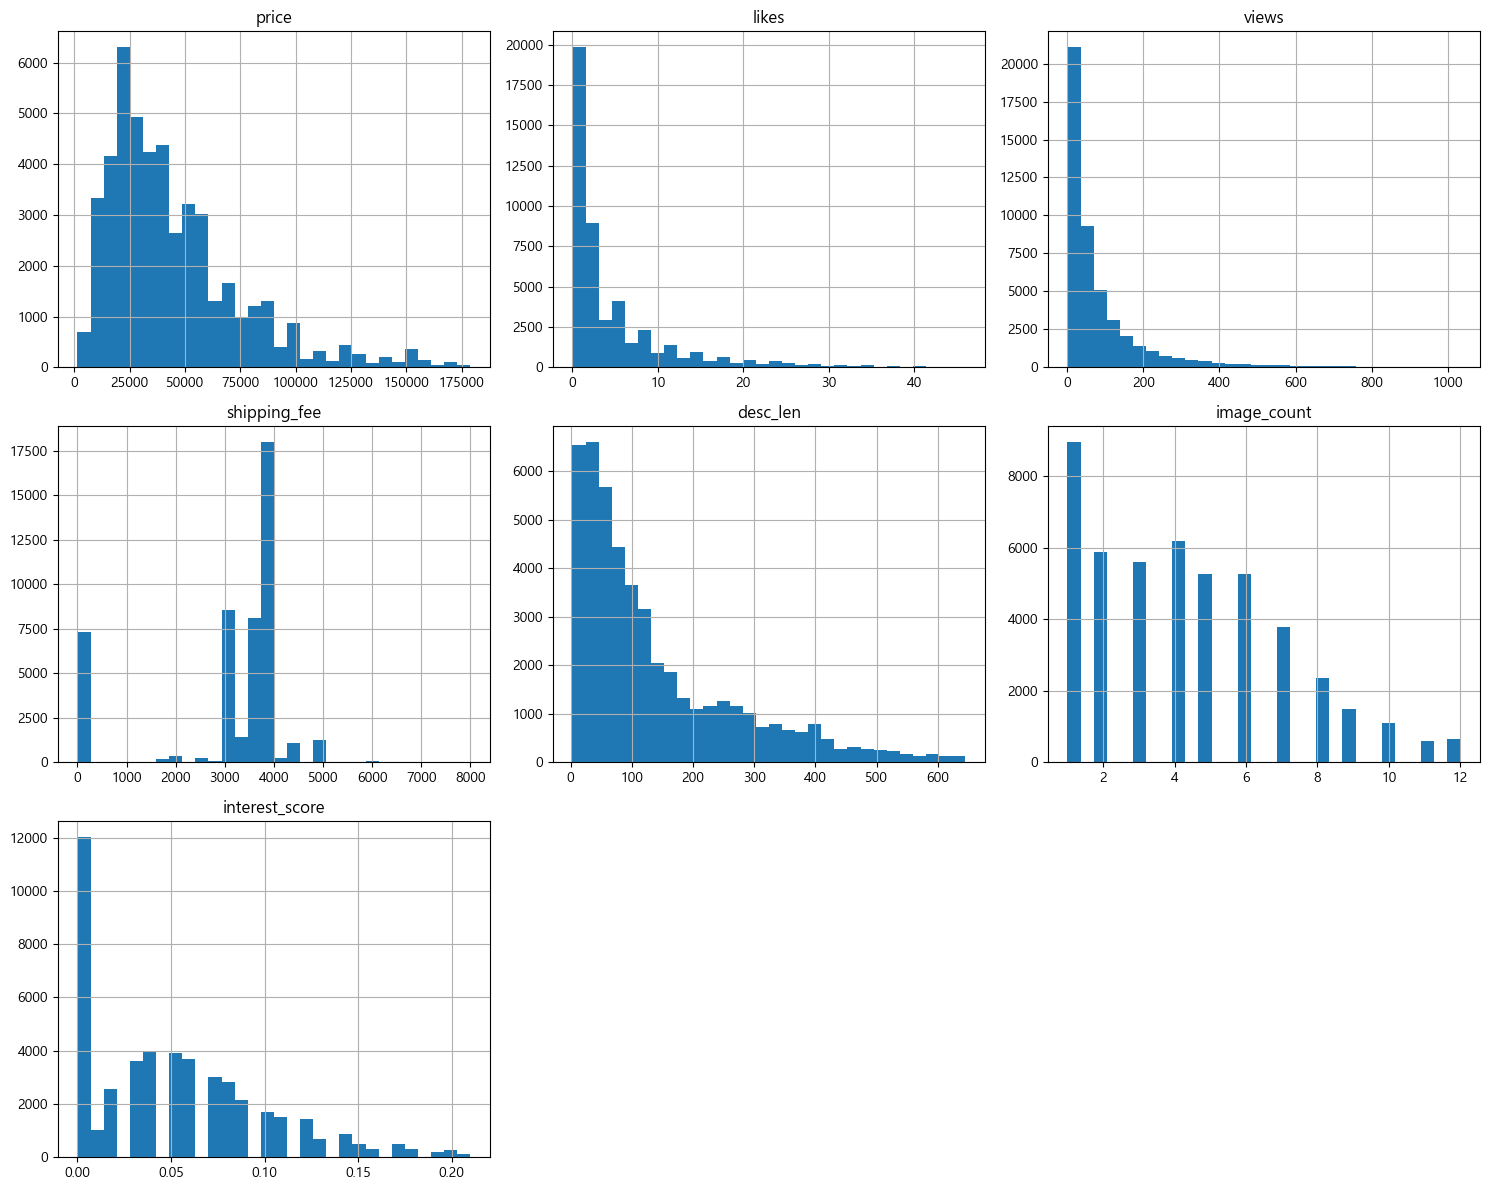

In [8]:
df_no_outliers = df[(np.abs(stats.zscore(df[numeric_cols])) < 3).all(axis=1)]
df_no_outliers[numeric_cols].hist(bins=30, figsize=(15, 12))
plt.tight_layout()
plt.show()

c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.draw()
c:\ProgramData\anaconda3\envs\myenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


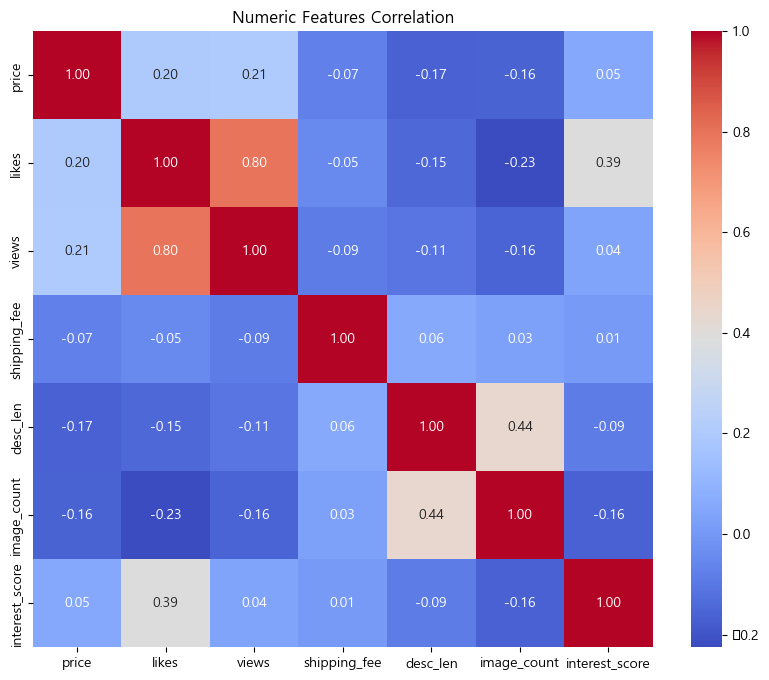

In [9]:
# 이상치 제거하고 상관관계 분석 (여전히 낮음)
plt.figure(figsize=(10, 8))
sns.heatmap(df_no_outliers[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Numeric Features Correlation')
plt.show()

목적 1: "2030 여성 취향 브랜드 상품군 공급 흐름 분석

In [10]:
#브랜드별 관심도 분석
df.groupby('brand_name')['interest_score'].mean().sort_values(ascending=False).head(20)

brand_name
글로니      0.076093
쓰리타임즈    0.074890
보헴서      0.067851
아디다스     0.053738
코스       0.051189
리즈리사     0.050376
자라       0.044555
폴로       0.042644
Name: interest_score, dtype: float64

In [11]:
#이상치 제거로 확인
df_no_outliers.groupby('brand_name')['interest_score'].mean().sort_values(ascending=False).head(20)

brand_name
글로니      0.073390
쓰리타임즈    0.071907
보헴서      0.067815
코스       0.050574
리즈리사     0.049918
아디다스     0.047382
자라       0.042649
폴로       0.040092
Name: interest_score, dtype: float64

목적 2: ‘믿고 찜’하는 중고 상품은 어떤 특징을 가졌는가?

In [12]:
# 가격대별 찜수 비교
df['price_group'] = pd.qcut(df['price'], q=3, labels=['저가', '중가', '고가'])
df.groupby('price_group')['likes'].mean()

C:\Users\jangj\AppData\Local\Temp\ipykernel_8884\3959742217.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('price_group')['likes'].mean()


price_group
저가    3.647855
중가    5.608269
고가    8.118080
Name: likes, dtype: float64

In [13]:
# 상품설명에 특정 단어가 포함된 경우 더 많은 찜이 있는가?
df['has_new'] = df['description'].str.contains('새상품|미개봉')
df.groupby('has_new')['likes'].mean()

has_new
False    5.278169
True     8.137207
Name: likes, dtype: float64

In [14]:
# likes 상위 5% 기준값
like_threshold = df_no_outliers['likes'].quantile(0.95)

# 상위 인기 상품 필터링
popular = df_no_outliers[df_no_outliers['likes'] > like_threshold]
normal = df_no_outliers[df_no_outliers['likes'] <= like_threshold]

# 수치형 특성 비교 대상
features = ['price', 'desc_len', 'image_count', 'interest_score']

summary = pd.DataFrame({
    '전체 평균': df_no_outliers[features].mean(),
    '인기 상품 평균': popular[features].mean(),
    '비인기 상품 평균': normal[features].mean()
})
print(summary)

                       전체 평균      인기 상품 평균     비인기 상품 평균
price           44564.611875  59517.250564  43827.118395
desc_len          139.015045     98.025282    141.036741
image_count         4.331975      2.874944      4.403839
interest_score      0.052415      0.082284      0.050941


[item_condition]에 따른 [likes] 평균:
item_condition
0     3.243243
1     4.667401
2    12.615658
3     3.766085
4     4.654900
5     6.351794
Name: likes, dtype: float64


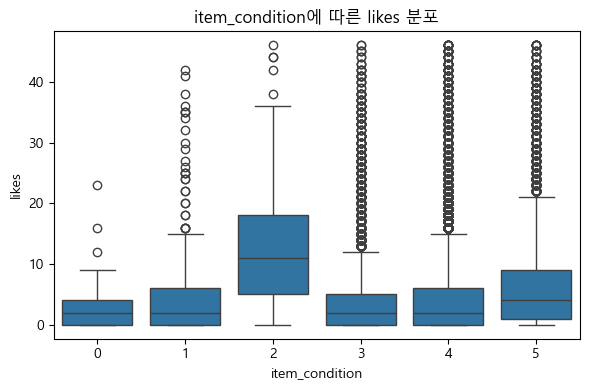

[item_condition]에 따른 [interest_score] 평균:
item_condition
0    0.034865
1    0.046982
2    0.037011
3    0.048233
4    0.052228
5    0.058077
Name: interest_score, dtype: float64


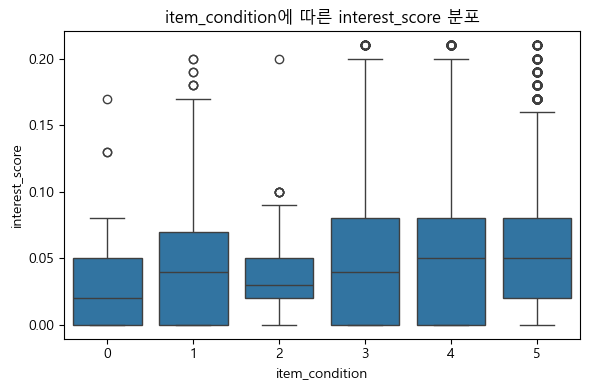

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 비교할 조건 변수
condition_cols = ['item_condition']

# 비교할 대상 변수
target_metrics = ['likes', 'interest_score']

# 평균 비교 및 시각화
for cond_col in condition_cols:
    for target_col in target_metrics:
        print(f"[{cond_col}]에 따른 [{target_col}] 평균:")
        print(df_no_outliers.groupby(cond_col)[target_col].mean())

        # 시각화
        plt.figure(figsize=(6, 4))
        sns.boxplot(data=df_no_outliers, x=cond_col, y=target_col)
        plt.title(f'{cond_col}에 따른 {target_col} 분포')
        plt.tight_layout()
        plt.show()
